In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.linear_model import LinearRegression
import requests
from bs4 import BeautifulSoup

In [9]:
def fetch_option_data(ticker):
    Ticker = yf.Ticker(ticker)
    expirations = Ticker.options
    
    option_data = pd.DataFrame()
    
    for expiration in expirations:
        option_chain = Ticker.option_chain(expiration)
        
        calls=option_chain.calls
        calls["Option Type"] = "Call"
        
        puts = option_chain.puts
        puts["Option Type"] = "Put"
        
        options = pd.concat([calls, puts])
        options["Expiration Date"] = pd.to_datetime(expiration) + pd.DateOffset(hours =23, minutes = 59, seconds=5)
        option_data = pd.concat([option_data,options])
        
    option_data["Days to Expiration"] = (option_data["Expiration Date"] - dt.datetime.today()).dt.days + 1
    return option_data  
                                             

In [87]:
options_data = fetch_option_data("^NDX")

In [88]:
call_options = options_data[options_data["Option Type"] == "Call"]

In [89]:
print("Available Expiration Dates:")
print(set(call_options["Expiration Date"]))

Available Expiration Dates:
{Timestamp('2024-05-20 23:59:05'), Timestamp('2024-06-14 23:59:05'), Timestamp('2025-12-19 23:59:05'), Timestamp('2024-06-11 23:59:05'), Timestamp('2026-12-18 23:59:05'), Timestamp('2024-06-04 23:59:05'), Timestamp('2024-06-10 23:59:05'), Timestamp('2024-10-18 23:59:05'), Timestamp('2024-05-31 23:59:05'), Timestamp('2024-06-06 23:59:05'), Timestamp('2025-02-21 23:59:05'), Timestamp('2024-12-20 23:59:05'), Timestamp('2025-03-31 23:59:05'), Timestamp('2025-01-17 23:59:05'), Timestamp('2024-06-28 23:59:05'), Timestamp('2024-05-22 23:59:05'), Timestamp('2024-06-05 23:59:05'), Timestamp('2024-09-30 23:59:05'), Timestamp('2024-11-15 23:59:05'), Timestamp('2025-05-16 23:59:05'), Timestamp('2024-06-13 23:59:05'), Timestamp('2025-06-20 23:59:05'), Timestamp('2024-05-28 23:59:05'), Timestamp('2024-06-21 23:59:05'), Timestamp('2024-05-23 23:59:05'), Timestamp('2024-07-05 23:59:05'), Timestamp('2024-08-16 23:59:05'), Timestamp('2025-04-17 23:59:05'), Timestamp('2024-05-

In [90]:
chosen_expiry_date = "2024-05-30 23:59:05"
selected_calls_at_expiry = call_options[call_options["Expiration Date"] == chosen_expiry_date]

In [91]:
filtered_calls_at_expiry = selected_calls_at_expiry[selected_calls_at_expiry["impliedVolatility"]>= 0.005]
filtered_calls_at_expiry.set_index("strike", inplace = True)

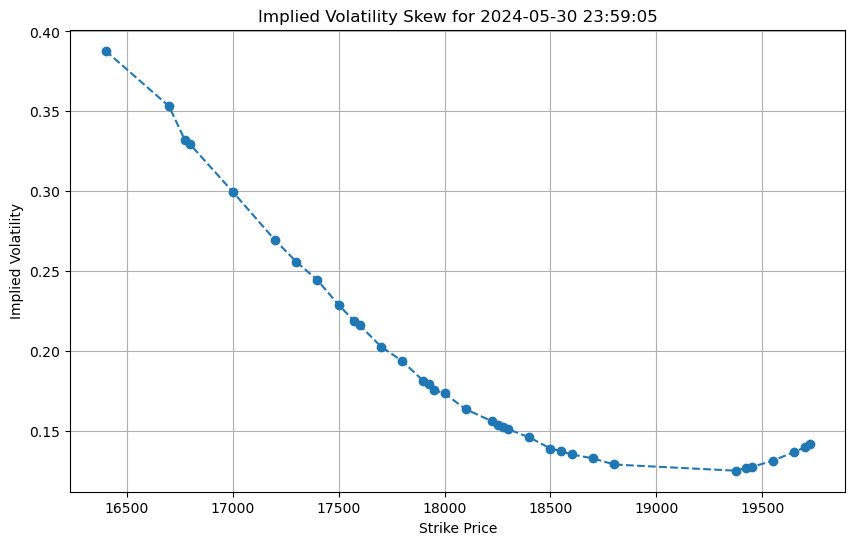

In [92]:
plt.figure(figsize=(10,6))
plt.plot(filtered_calls_at_expiry.index, filtered_calls_at_expiry["impliedVolatility"], marker = "o", linestyle = "--")
plt.title(f"Implied Volatility Skew for {chosen_expiry_date}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.grid(True)
          

In [93]:
selected_strike_price = 21800.0
selected_calls_at_strike = call_options[call_options["strike"] ==selected_strike_price]

In [94]:
filtered_calls_at_strike = selected_calls_at_strike[selected_calls_at_strike["impliedVolatility"] >= 0.001]

In [95]:
filtered_calls_at_strike.set_index("Expiration Date", inplace = True)

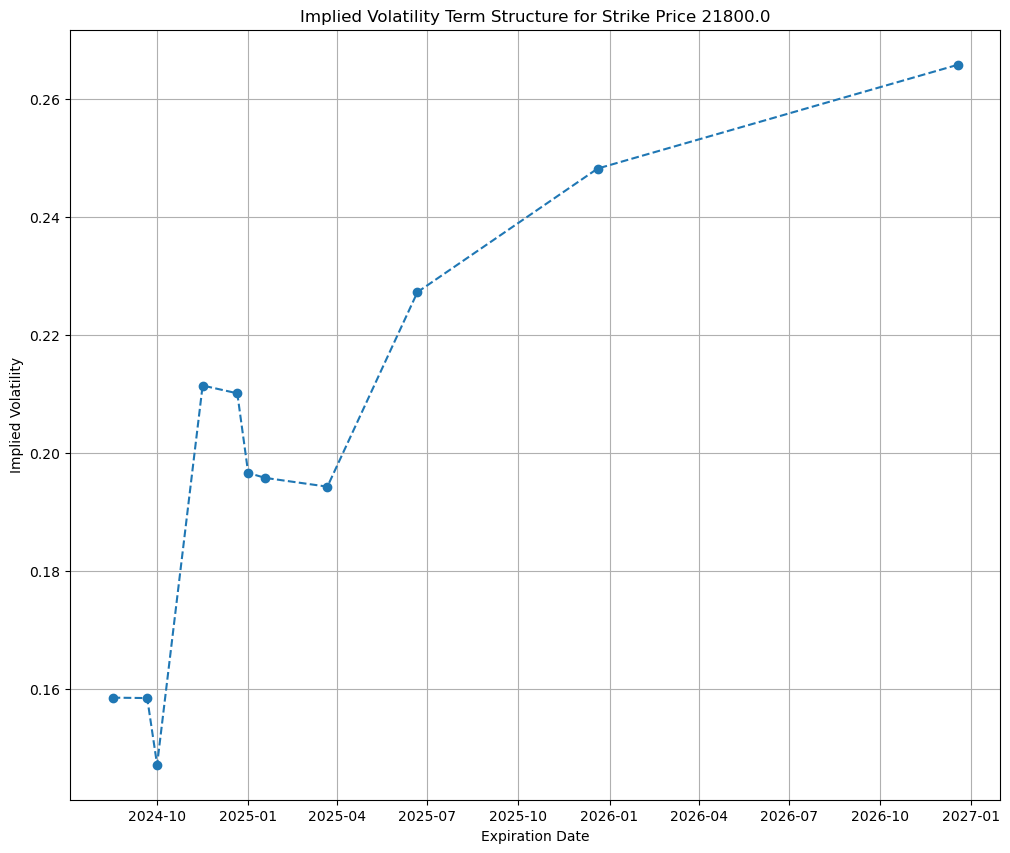

In [96]:
plt.figure(figsize=(12,10))
plt.plot(filtered_calls_at_strike.index, filtered_calls_at_strike["impliedVolatility"], marker = "o", linestyle = "--")
plt.title(f"Implied Volatility Term Structure for Strike Price {selected_strike_price}")
plt.xlabel("Expiration Date")
plt.ylabel("Implied Volatility")
plt.grid(True)
          

In [33]:
def get_options_data(ticker):
    stock = yf.Ticker(ticker)
    options = stock.options
    all_options = []

    for option_expiry in options:
        opt_chain = stock.option_chain(option_expiry)
        calls = opt_chain.calls
        puts = opt_chain.puts
        calls['type'] = 'call'
        puts['type'] = 'put'
        calls['expiry'] = option_expiry
        puts['expiry'] = option_expiry
        all_options.append(calls)
        all_options.append(puts)

    options_data = pd.concat(all_options, ignore_index=True)
    return options_data

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    else:
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))

    return price

def calculate_expected_return(option_data, stock_price, target_price, holding_period_days, volatility, risk_free_rate=0.01):
    option_data['expected_return'] = 0.0

    for idx, row in option_data.iterrows():
        T = holding_period_days / 365.0
        S = stock_price
        K = row['strike']
        sigma = volatility
        r = risk_free_rate

        option_price = black_scholes(S, K, T, r, sigma, row['type'])
        if row['type'] == 'call':
            intrinsic_value = max(0, target_price - K)
        else:
            intrinsic_value = max(0, K - target_price)

        holding_period_return = (intrinsic_value - option_price) / option_price if option_price != 0 else 0
        annualized_return = holding_period_return * (365 / holding_period_days)
        option_data.at[idx, 'expected_return'] = annualized_return

    return option_data

def find_best_option(option_data):
    best_option = option_data.loc[option_data['expected_return'].idxmax()]
    return best_option

def forecast_target_price(ticker, holding_period_days):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period="35y")['Close']
    
    model = ARIMA(historical_data, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=holding_period_days)
    
    target_price = pd.DataFrame(forecast)['predicted_mean'].iloc[-1]
    return target_price

#ticker = "^NDX" #"AAPL" #stock pursued
holding_period_days = 30  # Investment horizon in days 
risk_free_rate = 0.01  # 1% annual risk-free rate
ticker_list = ["^NDX", "AAPL", "AMZN","MSFT", "GOOGL","TSLA", "NFLX", "JPM", "NVDA", "V"]
results_list = []

for ticker in ticker_list:
    options_data = get_options_data(ticker)
    stock = yf.Ticker(ticker) 
    current_stock_price = stock.history(period="1d")['Close'].iloc[-1]
    historical_data = stock.history(period="1y") 
    returns = historical_data['Close'].pct_change().dropna()
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility

    target_price = forecast_target_price(ticker, holding_period_days)
    #print(f"Forecasted target price for {ticker} in {holding_period_days} days: {target_price}")

    options_data = calculate_expected_return(options_data, current_stock_price, target_price, holding_period_days, volatility, risk_free_rate)

    best_option = find_best_option(options_data)
    results_list.append((best_option['expected_return'],best_option, target_price, ticker))
    #print("Best Option to Purchase:")
    #print(best_option)
max_value = max(results_list, key=lambda x: x[0])
max_value

C:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Pred

(0.2468151648272216,
 contractSymbol            GOOGL240524P00210000
 lastTradeDate        2024-04-26 13:38:45+00:00
 strike                                   210.0
 lastPrice                                 36.4
 bid                                      32.95
 ask                                       35.8
 change                                     0.0
 percentChange                              0.0
 volume                                     1.0
 openInterest                                 0
 impliedVolatility                     0.775881
 inTheMoney                                True
 contractSize                           REGULAR
 currency                                   USD
 type                                       put
 expiry                              2024-05-24
 expected_return                       0.246815
 Name: 82, dtype: object,
 175.46200493829085,
 'GOOGL')